In [1]:
# this model includes ql
# it uses instantaneous bedrock erosion rate to calc ql
# it uses gamma to represent fraction of plucked material that becomes coarse gravel
# it uses theta to represent fraction of hillslope material that enters fluvial system as coarse 
## (maybe this should be same as gamma, 
## since the real fxn of this parameter is to tell us 
## how much coarse stuff is available for bedload transport/abrasion)

# potential updates: see if adding weighted average back in to ql calculation still allows for stability
## update on the update: this led to stability issues, and it's not worth the time now trying to debug, 
## so just stick with using instantaneous erosion rate. 
## Most interested in steady state profiles anyway, so this is fine.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# create a profile
dx = 500
x = np.arange(0, 50000, dx)
x_node = x + (dx/2)

# add some elevation
Hstar = 0.5 # depth decay
etab = np.zeros(len(x)) # bedrock elevation
etab[:] = np.linspace(1, 0.1, len(x)) # need to start with slight bedrock slope
H = Hstar + np.zeros(len(x)) # alluvium thickness
eta = etab + H # topography

In [4]:
# define constants and other parameters
K = 1e-6 # erodibility
beta = 0.0005 # abradability
r = 5. # runoff rate
U = 0.0001 # uplift or baselevel fall rate
I = 0.01 # intermittency
phi = 0.1 # porosity
D = 0.01 # grain size
gamma = 0.5 # fraction plucked that becomes coarse

kqs = 0.061 # sed transport coeff
kxb = 25 # valley width coeff
Pxb = 1./5. # valley width exp
kb = 8.3e-8 # channel width coeff

B_valley = kxb * (x_node**Pxb) # valley width
# Q = (r * kxb * x_node**(1 + Pxb))/(1 + Pxb) # discharge
A = (1./3.) * (x**2)
Q = r * A

In [5]:
def model(x, dx, x_node,
          K, beta, gamma,
          D, phi, Hstar,
          kb, kqs, I, r, U,
          etab, H, eta,
          B_valley, Q,
          num_steps = 1):
    
    q = Q/B_valley
    dt = 30
    
    run_duration = dt * num_steps
    cum_time = 0.0
    
    Qs = np.zeros(len(x))
    qs = np.zeros(len(x))
    Eb_p = np.zeros(len(x))
    Eb_a = np.zeros(len(x))
    Eb = np.zeros(len(x))
    Eh = np.zeros(len(x))
    E = np.zeros(len(x))
    ql = np.zeros(len(x)) # lateral sediment supply
    
    H[-1] = 0
    E[-1] = U
    q[0] = 0
    Qs[0] = 0
    
    while cum_time < run_duration:
        
        # drop baselevel
        eta[-1] -= U * dt
        
        # set boundary conditions
        etab[-1] = eta[-1]
        
        # calc slope
        S = -np.diff(eta)/dx
        
        # calc bed exposure
        alpha = np.exp(-H/Hstar)
        
        # calc sed transport
        Qs[1:] = kqs * I * Q[1:] * S**(7./6.) * (1 - alpha[:-1])
        qs[1:] = Qs[1:] / B_valley[1:]
        
        # calc bedrock erosion
        Eb_p[:-1] = K * Q[1:] * S**(7./6.) * alpha[:-1] * I
        Eb_a[:-1] = beta * Qs[1:] * alpha[:-1]
        Eb[:-1] = (Eb_p[:-1] + Eb_a[:-1]) / B_valley[:-1]
        
        # calc lateral flux
        ql[:-1] = ((Eb[:-1] * gamma)/beta) * (1 - np.exp(-beta * x[1:]/3))
        
        # calc grain attrition
        atr = Qs * beta
        
        # calc sediment erosion rate
        Eh[:-1] = 1/((1 - phi) * B_valley[:-1]) * (np.diff(Qs)/dx + atr[1:] - (Eb_p[:-1]*gamma) - ql[:-1])
        
        # calc total erosion rate
        E[:-1] = Eb[:-1] + Eh[:-1]
        
        # update topography
        etab[:-1] -= Eb[:-1] * dt
        H[:-1] -= Eh[:-1] * dt
        H[H<0] = 0
        eta[:-1] = etab[:-1] + H[:-1]
        
        # update elapsed time
        cum_time += dt
        
    print(cum_time)
        
    return (dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta)

In [6]:
#now write a test
num_steps = 50000000

test_run = [x, dx, x_node, 
            K, beta, gamma,
            D, phi, Hstar,
            kb, kqs, I, r, U,
            etab, H, eta,
            B_valley, Q,
            num_steps]

# and run it
(dt, S, q, alpha, Qs, qs, Eb_p, Eb_a, Eb, ql, atr, Eh, E, etab, H, eta) = model(*test_run)

1500000000.0


In [7]:
Eb

array([1.00000000e-04, 1.00000000e-04, 9.99999999e-05, 9.99999999e-05,
       9.99999999e-05, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
       1.00000000e-04, 1.00000000e-04, 1.00000000e-04, 1.00000000e-04,
      

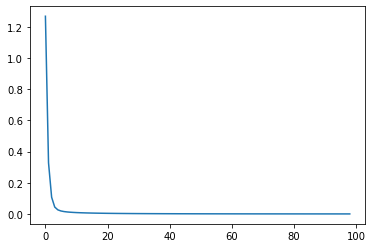

In [8]:
plt.plot(S)

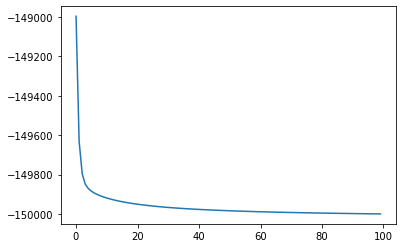

In [9]:
plt.plot(eta)

In [10]:
S[-1]

0.00037820516497595233

In [11]:
eta

array([-148996.87659516, -149631.05186065, -149795.1523199 ,
       -149848.79942012, -149870.99540464, -149884.2366262 ,
       -149893.88189112, -149901.60308187, -149908.10369406,
       -149913.74410557, -149918.73499187, -149923.21163444,
       -149927.26716692, -149930.96920812, -149934.36892783,
       -149937.50633603, -149940.41354579, -149943.11688198,
       -149945.63829944, -149947.99636976, -149950.20698891,
       -149952.28389783, -149954.23907452, -149956.08303532,
       -149957.82507049, -149959.47343156, -149961.03548222,
       -149962.51782152, -149963.92638548, -149965.26653175,
       -149966.54311081, -149967.76052628, -149968.92278632,
       -149970.03354781, -149971.09615452, -149972.11367014,
       -149973.08890717, -149974.02445218, -149974.92268803,
       -149975.78581344, -149976.61586035, -149977.41470932,
       -149978.18410321, -149978.92565947, -149979.64088105,
       -149980.33116621, -149980.99781741, -149981.64204921,
       -149982.26499545,

In [12]:
eta_adj = eta - eta[-1]

In [13]:
eta_adj

array([1.00252329e+03, 3.68348026e+02, 2.04247567e+02, 1.50600466e+02,
       1.28404482e+02, 1.15163260e+02, 1.05517995e+02, 9.77968045e+01,
       9.12961924e+01, 8.56557808e+01, 8.06648945e+01, 7.61882520e+01,
       7.21327195e+01, 6.84306783e+01, 6.50309586e+01, 6.18935504e+01,
       5.89863406e+01, 5.62830044e+01, 5.37615870e+01, 5.14035166e+01,
       4.91928975e+01, 4.71159886e+01, 4.51608119e+01, 4.33168511e+01,
       4.15748159e+01, 3.99264549e+01, 3.83644042e+01, 3.68820649e+01,
       3.54735009e+01, 3.41333547e+01, 3.28567756e+01, 3.16393601e+01,
       3.04771001e+01, 2.93663386e+01, 2.83037319e+01, 2.72862163e+01,
       2.63109792e+01, 2.53754342e+01, 2.44771984e+01, 2.36140730e+01,
       2.27840261e+01, 2.19851771e+01, 2.12157832e+01, 2.04742269e+01,
       1.97590054e+01, 1.90687202e+01, 1.84020690e+01, 1.77578372e+01,
       1.71348910e+01, 1.65321706e+01, 1.59486849e+01, 1.53835055e+01,
       1.48357622e+01, 1.43046387e+01, 1.37893684e+01, 1.32892305e+01,
      

In [14]:
# save csv files

np.savetxt('elevation csv files/eta_exp_12.csv', eta_adj, delimiter = ',')
np.savetxt('alpha csv files/alpha_exp_12.csv', alpha, delimiter = ',')
np.savetxt('slope csv files/slope_exp_12.csv', S, delimiter = ',')

In [15]:
# calc width

b = (kb * Q[1:] * S**(7/6)) / (D**(3/2))

np.savetxt('width csv files/b_exp_12.csv', b, delimiter = ',')
np.savetxt('Qs csv files/Qs_exp_12.csv', Qs, delimiter = ',')